In [ ]:
# Exporting the notebook. It may take several seconds....

[NbConvertApp] Converting notebook SMOTE_transaction_Li.ipynb to script
[NbConvertApp] Writing 7641 bytes to SMOTE_transaction_Li.py


imbalanced_learn==0.6.2
numpy==1.18.1
matplotlib==3.0.2
xgboost==1.1.0
seaborn==0.9.0
pandas==0.25.3
imblearn==0.0
scikit_learn==0.23.2


INFO: Successfully output requirements


In [6]:
## $xpr_param_component_name == data_clean
## $xpr_param_component_type == pipeline_job
## $xpr_param_global_variables == ["dat_X", "dat_target"]
## $xpr_param_global_methods == ["clean_data"]

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve,precision_recall_curve,average_precision_score
import seaborn as sns
from imblearn.over_sampling import SMOTE,SVMSMOTE

Using TensorFlow backend.


In [4]:
# data feature engineering 
train = pd.read_csv('train.csv').iloc[:,1:]

X_train_split, X_val_split = train_test_split(train, test_size=0.2,
                                   stratify=train['target'], 
                                   random_state=1)

y_train = X_train_split['target']
X_train = X_train_split.drop(['target'], axis=1)

y_val = X_val_split['target']
X_val = X_val_split.drop(['target'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_val.shape,', shape Y',y_val.shape)


Train: shape X (160000, 200) , shape Y (160000,)
Test: shape X (40000, 200) , shape Y (40000,)


In [5]:
# Random Forest component

# example for fit_predict_score function
# this is data without oversampling 
## $xpr_param_component_name == model
## $xpr_param_component_type == pipeline_job
## $xpr_param_global_variables == ["X_train", "y_train"]
## $xpr_param_global_methods == ["clean_data", "modeling"]
def fit_predict_score(data_X,data_Y,name,clf):
   # X_train,X_test,y_train,y_test =train_test_split(data_X,data_Y,test_size=0.3,random_state=42)
    classifier=clf
    clf.fit(data_X, data_Y)
    predicted = clf.predict(X_val)  # prediction for validation 
    fitted_y=clf.predict(data_X)   # prediction for train 
    y_prob=clf.predict_proba(X_val)[:,1] # predict proba for validation 
    y_prob_train=clf.predict_proba(data_X)[:,1] 
    print("Processing...")
    
    confusion_matrix =  pd.crosstab(index=y_val, 
                                    columns=predicted.ravel(), 
                                    rownames=['Expected'], 
                                    colnames=['Predicted'])
    
    accuracy = np.round(accuracy_score(y_val , predicted),3)
    sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
    plt.title(name + ", Accuracy: " + str(accuracy), fontsize = 15)
    plt.show()
    
    brier=brier_score_loss(y_val, y_prob)
    average_precision = average_precision_score(y_val, y_prob)
    
    brier_train=brier_score_loss(data_Y, y_prob_train)
    disp = plot_precision_recall_curve(classifier, X_val, y_val)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    
    print("Model parameters ", "\n", classifier)
    
    print("Classification report for classifier in test ","\n",
               classification_report(y_val, predicted))
    print("Classification report for classifier in train ","\n",
              classification_report(data_Y, fitted_y))
    
    print("Brier Score for Train: ","\n",brier_train)
    print("Brier Score for Test: ","\n",brier)
    
    
    
    

Processing...


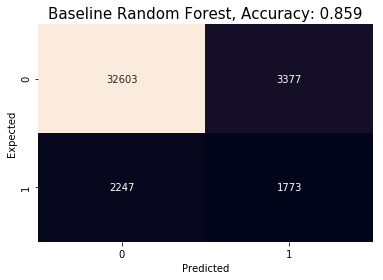

Model parameters  
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.94      0.91      0.92     35980
           1       0.34      0.44      0.39      4020

    accuracy                           0.86     40000
   macro avg       0.64      0.67      0.65     40000
weighted avg       0.88      0.86      0.87     40000

Classification report for classifier in train  
     

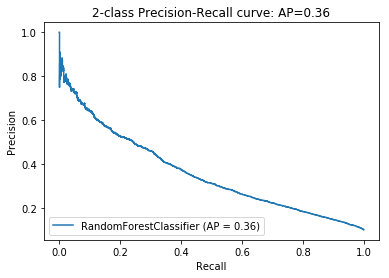

In [37]:

fit_predict_score(X_train,y_train,name="Baseline Random Forest",
                  clf=RandomForestClassifier(random_state=42,max_features="sqrt",max_depth=10,
                                             criterion="entropy",class_weight="balanced"))

In [3]:
# xbgoost component
 
## $xpr_param_component_name == xgboost_model
## $xpr_param_component_type == pipeline_job
## $xpr_param_global_variables == ["X_train", "y_train"]
## $xpr_param_global_methods == ["clean_data", "modeling"]
import xgboost as xgb

D_val = xgb.DMatrix(X_val, label=y_val)

param = {
    'eta': 0.01, 
    'max_depth': 10, 
    'objective': 'binary:logistic',  
    'lambda': 0.2} 

steps = 20

def xgb_function(train_x,train_y,name):
    D_train = xgb.DMatrix(train_x, label=train_y)
    model_xgb = xgb.train(param, D_train,num_boost_round=30)
    # save model
    preds_xgb = model_xgb.predict(D_val)
    preds_train_xgb = model_xgb.predict(D_train)
    preds_xgb_class = np.where(preds_xgb >0.5, 1, 0)
    fitted_xgb=np.where(model_xgb.predict(D_train) >0.5, 1, 0)
    # best_preds
    confusion_xgb_matrix =  pd.crosstab(index=y_val, columns=preds_xgb_class.ravel(), 
                                    rownames=['Expected'], colnames=['Predicted'])
    sns.heatmap(confusion_xgb_matrix, annot=True, square=False, fmt='', cbar=False)
    accuracy_xgb = np.round(accuracy_score(y_val , preds_xgb_class),3)
    plt.title(name + ", Accuracy: " + str(accuracy_xgb), fontsize = 15)
    plt.show()
    print("Classification report for classifier %s:"
     % (classification_report(y_val, preds_xgb_class)))
    
    
    brier=brier_score_loss(y_val, preds_xgb)
    
    brier_train=brier_score_loss(train_y, preds_train_xgb)
    
    print("Classification report for classifier in test ","\n",
               classification_report(y_val, preds_xgb_class))
    print("Classification report for classifier in train ","\n",
              classification_report(train_y, fitted_xgb))
    
    print("Brier Score for test: ","\n",brier)
    print("Brier Score for train: ","\n",brier_train)

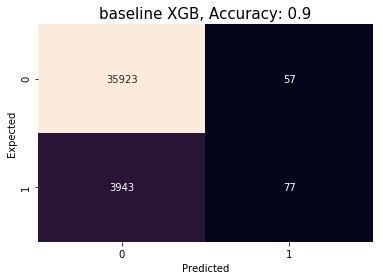

Classification report for classifier               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.57      0.02      0.04      4020

    accuracy                           0.90     40000
   macro avg       0.74      0.51      0.49     40000
weighted avg       0.87      0.90      0.86     40000
:
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.57      0.02      0.04      4020

    accuracy                           0.90     40000
   macro avg       0.74      0.51      0.49     40000
weighted avg       0.87      0.90      0.86     40000

Classification report for classifier in train  
               precision    recall  f1-score   support

           0       0.91      1.00      0.95    143922
           1       1.00      0.10      0.19     16078

    accuracy                           0.91    

In [16]:
xgb_function(X_train,y_train,'baseline XGB')
# save model everytime 

In [7]:
# imbalance ratio in train 
# original_ratio=len(y_train[y_train==1])/len(y_train[y_train==0])

In [8]:
# val_ratio=len(y_val[y_val==1])/len(y_val[y_val==0])
# val_ratio

0.11172873818788216

In [9]:
# original_ratio

0.11171328914273009

In [10]:
# Smote transformation, take train and test data, output is SMOTE data
## $xpr_param_component_name == smote_transform
## $xpr_param_component_type == pipeline_job
## $xpr_param_global_variables == ["X_train", "y_train"]
## $xpr_param_global_methods == ["clean_data", "modeling"]

def smote_transform(ratio):
    sm = SMOTE(random_state=42,sampling_strategy=ratio)
    X_smote, y_smote = sm.fit_resample(X_train,y_train)
    return X_smote,y_smote

# need to save all transformed data into desk, from location to read training.

0.15
Processing...


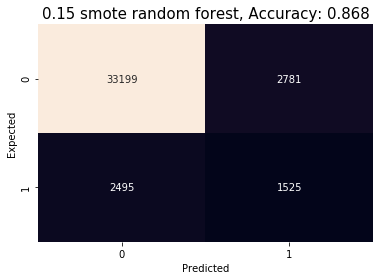

Model parameters  
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     35980
           1       0.35      0.38      0.37      4020

    accuracy                           0.87     40000
   macro avg       0.64      0.65      0.65     40000
weighted avg       0.87      0.87      0.87     40000

Classification report for classifier in train  
     

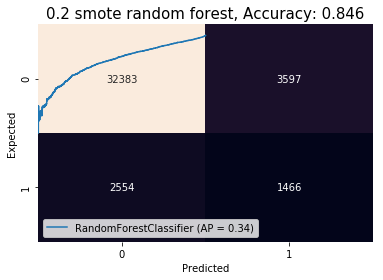

Model parameters  
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.93      0.90      0.91     35980
           1       0.29      0.36      0.32      4020

    accuracy                           0.85     40000
   macro avg       0.61      0.63      0.62     40000
weighted avg       0.86      0.85      0.85     40000

Classification report for classifier in train  
     

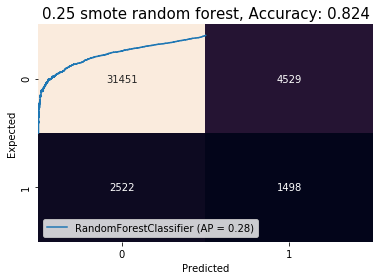

Model parameters  
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.93      0.87      0.90     35980
           1       0.25      0.37      0.30      4020

    accuracy                           0.82     40000
   macro avg       0.59      0.62      0.60     40000
weighted avg       0.86      0.82      0.84     40000

Classification report for classifier in train  
     

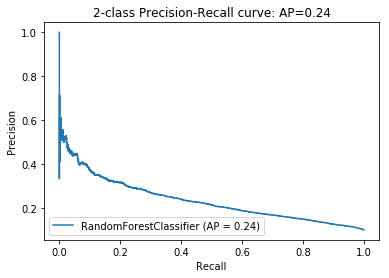

In [36]:
# create one more component: create a new dataset after SMOTE
# ratios=list(np.arange(0.15,0.3,0.05))
# for ratio in ratios:
#     print(ratio)
#     names= str(round(ratio,3))+' smote random forest'
#     sm = SMOTE(random_state=42,sampling_strategy=ratio)
#     X_smote, y_smote = sm.fit_resample(X_train,y_train)
#     fit_predict_score(X_smote,y_smote,name=names,clf=RandomForestClassifier(max_depth=10, random_state=42,
#                                                           max_features="sqrt",criterion="entropy",
#                                                                         class_weight="balanced"))
#     print('\n')
    

Processing...


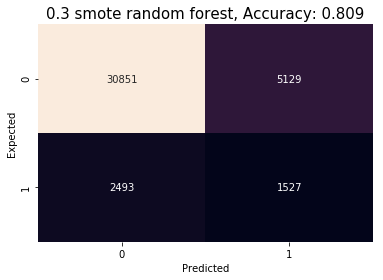

Model parameters  
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.93      0.86      0.89     35980
           1       0.23      0.38      0.29      4020

    accuracy                           0.81     40000
   macro avg       0.58      0.62      0.59     40000
weighted avg       0.86      0.81      0.83     40000

Classification report for classifier in train  
     

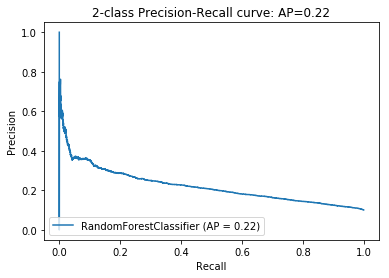

In [5]:
sm = SMOTE(random_state=42,sampling_strategy=0.3)
X_smote, y_smote = sm.fit_resample(X_train,y_train)
fit_predict_score(X_smote,y_smote,name='0.3 smote random forest',clf=RandomForestClassifier(max_depth=10, random_state=42,
                                                          max_features="sqrt",criterion="entropy",
                                                                        class_weight="balanced"))


0.15


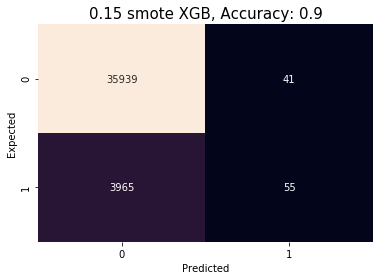

Classification report for classifier               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.57      0.01      0.03      4020

    accuracy                           0.90     40000
   macro avg       0.74      0.51      0.49     40000
weighted avg       0.87      0.90      0.85     40000
:
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.57      0.01      0.03      4020

    accuracy                           0.90     40000
   macro avg       0.74      0.51      0.49     40000
weighted avg       0.87      0.90      0.85     40000

Classification report for classifier in train  
               precision    recall  f1-score   support

           0       0.88      1.00      0.94    143922
           1       1.00      0.11      0.20     21588

    accuracy                           0.88    

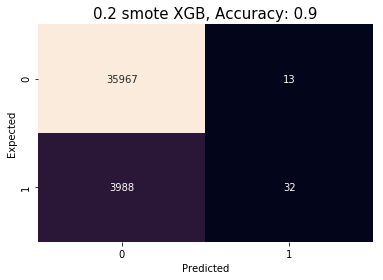

Classification report for classifier               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.71      0.01      0.02      4020

    accuracy                           0.90     40000
   macro avg       0.81      0.50      0.48     40000
weighted avg       0.88      0.90      0.85     40000
:
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.71      0.01      0.02      4020

    accuracy                           0.90     40000
   macro avg       0.81      0.50      0.48     40000
weighted avg       0.88      0.90      0.85     40000

Classification report for classifier in train  
               precision    recall  f1-score   support

           0       0.85      1.00      0.92    143922
           1       1.00      0.09      0.17     28784

    accuracy                           0.85    

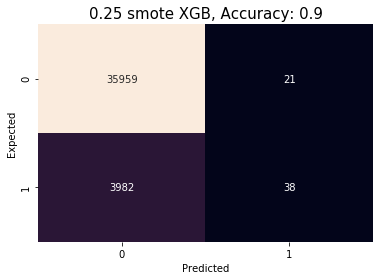

Classification report for classifier               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.64      0.01      0.02      4020

    accuracy                           0.90     40000
   macro avg       0.77      0.50      0.48     40000
weighted avg       0.87      0.90      0.85     40000
:
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.64      0.01      0.02      4020

    accuracy                           0.90     40000
   macro avg       0.77      0.50      0.48     40000
weighted avg       0.87      0.90      0.85     40000

Classification report for classifier in train  
               precision    recall  f1-score   support

           0       0.82      1.00      0.90    143922
           1       1.00      0.09      0.17     35980

    accuracy                           0.82    

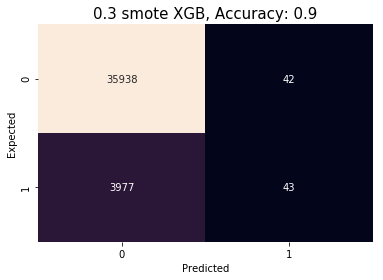

Classification report for classifier               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.51      0.01      0.02      4020

    accuracy                           0.90     40000
   macro avg       0.70      0.50      0.48     40000
weighted avg       0.86      0.90      0.85     40000
:
Classification report for classifier in test  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95     35980
           1       0.51      0.01      0.02      4020

    accuracy                           0.90     40000
   macro avg       0.70      0.50      0.48     40000
weighted avg       0.86      0.90      0.85     40000

Classification report for classifier in train  
               precision    recall  f1-score   support

           0       0.79      1.00      0.88    143922
           1       0.98      0.11      0.20     43176

    accuracy                           0.79    

In [5]:
ratios=list(np.arange(0.15,0.35,0.05))
for ratio in ratios:
    print(ratio)
    names= str(round(ratio,3))+' smote XGB'
    sm = SMOTE(random_state=42,sampling_strategy=ratio)
    X_smote, y_smote = sm.fit_resample(X_train,y_train)
    xgb_function(X_smote,y_smote,names)
    print('\n')